In [1]:
import pandas  as pd
import numpy   as np
import xgboost as xgb

In [3]:
train_data= pd.read_csv("train.csv")
train_data.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [4]:
train_data.keys()

Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')

In [12]:
train_data.isnull().sum()

id                   0
squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22730 entries, 0 to 22729
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 22730 non-null  int64  
 1   squareMeters       22730 non-null  int64  
 2   numberOfRooms      22730 non-null  int64  
 3   hasYard            22730 non-null  int64  
 4   hasPool            22730 non-null  int64  
 5   floors             22730 non-null  int64  
 6   cityCode           22730 non-null  int64  
 7   cityPartRange      22730 non-null  int64  
 8   numPrevOwners      22730 non-null  int64  
 9   made               22730 non-null  int64  
 10  isNewBuilt         22730 non-null  int64  
 11  hasStormProtector  22730 non-null  int64  
 12  basement           22730 non-null  int64  
 13  attic              22730 non-null  int64  
 14  garage             22730 non-null  int64  
 15  hasStorageRoom     22730 non-null  int64  
 16  hasGuestRoom       227

In [19]:
X = train_data.drop("price", axis=1)
y = train_data["price"]

In [31]:
X = X.drop("id", axis=1)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((15229, 16), (7501, 16))

In [33]:
from sklearn.model_selection import GridSearchCV
regressor=xgb.XGBRegressor(eval_metric='rmsle')
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

In [34]:
grid_search = GridSearchCV(
    regressor,
    param_grid,
    cv = 3,
    #scoring = 'precision',
    n_jobs = 1,   
    verbose = 3, #error_score='raise',
    return_train_score =False
)
result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=500;, score=0.995 total time=   2.0s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=500;, score=0.997 total time=   2.0s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=500;, score=0.998 total time=   1.7s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=600;, score=0.995 total time=   2.1s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=600;, score=0.997 total time=   2.1s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=600;, score=0.998 total time=   2.1s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=700;, score=0.995 total time=   2.5s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=700;, score=0.997 total time=   2.5s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=700;, score=0.998 total time=   2.5s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=500;, score=0.99

In [35]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9967274151284222
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 700}


In [40]:
regressor=xgb.XGBRegressor(n_estimators=600, max_depth=4, learning_rate= 0.01 , eval_metric='rmsle')
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

In [41]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse
    

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

In [42]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [43]:
mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
xgb_rmse_cross_val = rmse_cv(regressor)
print("RMSE Cross-Validation:", xgb_rmse_cross_val)

MAE: 23471.57813176994
MSE: 38262844247.83184
RMSE: 195608.90636121822
R2 Score: 0.9955746529400207
------------------------------
RMSE Cross-Validation: 159182.88589454483


In [47]:
test_data  = pd.read_csv('test.csv',index_col=0)
test_data.shape
# test_data['RANDOM'] = np.random.normal(size=len(test_data))
X_examine = test_data
X_examine = X_examine.fillna(X_examine.mean())

X_examine.shape

submission = regressor.predict(X_examine)

pd.DataFrame({"Id":test_data.index, "SalePrice":submission}).to_csv("submission-2.csv", index=False)

In [50]:
solution = pd.read_csv('sample_submission.csv')
y_true  = solution["price"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, submission) )
print("The score is %.5f" % RMSLE )

The score is 1.15017


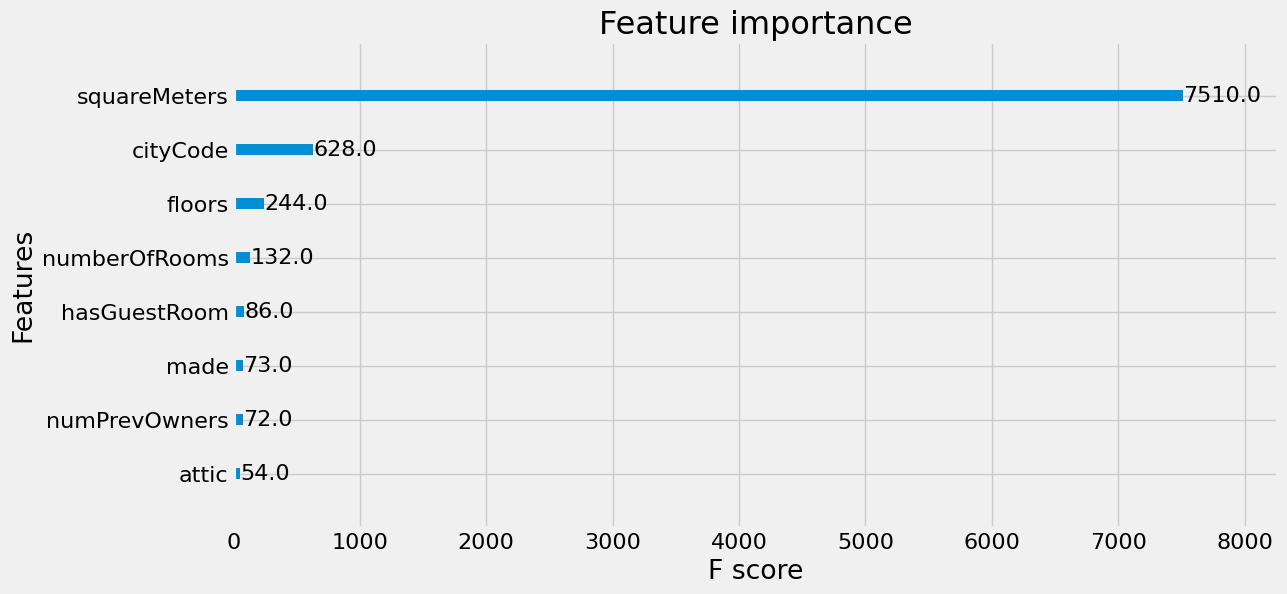

In [51]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

In [52]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


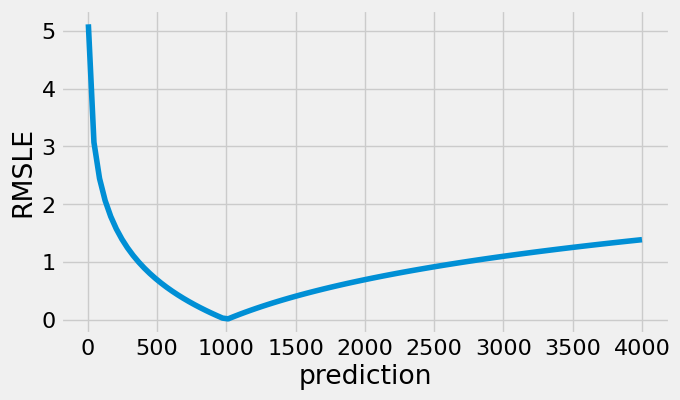

In [53]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()